In [1]:
# Import Libraries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVC

In [2]:
# Helper Functions - Color, Histogram, HOG

# Function to get the correct Color Space 
def get_color_space(img, color_space='RGB'):
     # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'BGR2YCrCb':
            feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_img = np.copy(img)
    return feature_img
# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    features = np.hstack((color1, color2, color3))
    # Return the feature vector
    return features
    
# Function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Function to get HOG features 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
             
        feature_image = get_color_space(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Function to add heat to get image ready to reject false positives
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes

# If the classifier is working well, then the "hot" parts of the map 
# are where the cars are, and by imposing a threshold, you can reject 
# areas affected by false positives. 

# Function to reject false positives
def reject_false_positives(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [3]:
# Function that can extract features using hog sub-sampling and make predictions
def find_vehicles(img, ystart, ystop, scale, svc, X_scaler, c_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rect_windows = [] 
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = get_color_space(img_tosearch, color_space=c_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    '''
    print('nblocks_per_window', nblocks_per_window)
    print('nxsteps', nxsteps)
    print('nysteps', nysteps)
    '''
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            if spatial_feat == True and hist_feat == True and hog_feat == True:
                #print("spat + hist + hog")
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            elif spatial_feat == True and hist_feat == True:
                #print("spat + hist")
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1))
            elif spatial_feat == True and hog_feat == True:
                #print("spat + hog")
                test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            elif hist_feat == True and hog_feat == True:
                #print("hist + hog")
                test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
            else:
                #print("hog")
                test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1)) 
            
            '''
            dec = svc.decision_function(test_features)
            test_prediction = int(dec > 0.75)
            '''
            test_prediction = svc.predict(test_features)
           
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                '''
                print('xbox_left', xbox_left)
                print('ytop_draw', ytop_draw)
                print('win_draw', win_draw)
                '''
                rect_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
            
    #return draw_img
    return rect_windows

In [4]:
# A function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thickness=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Random color
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thickness)
    # Return the image copy with boxes drawn
    return imcopy

# Function to draw bounding boxes on detected vehicles
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [5]:
# Function to train the classifier
def train_classifier(vehicle_images, non_vehicle_images, C_val=1000):
    print('Starting to Train Classifier')
    vehicle_features = extract_features(vehicle_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    not_vehicle_features = extract_features(non_vehicle_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((vehicle_features, not_vehicle_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(not_vehicle_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    #find_best_hyper_parameters(X_train, X_test, y_train, y_test)
    
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC(C=C_val)
    # Check the training time for the SVC
    start_time=time.time()
    svc.fit(X_train, y_train)
    end_time = time.time()
    print(round(end_time-start_time, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    print('Finished Training Classifier')
    return (svc, X_scaler)

In [6]:
# This function should take in two lists (vehicle_list and not_vehicle_list) and returns 
# a dictionary with the keys "n_vehicles", "n_not_vehicles", "image_shape", and "data_type"
def explore_dataset(vehicle_list, not_vehicle_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_vehicles"] = len(vehicle_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_not_vehicles"] = len(not_vehicle_list)
    # Read in a test image, either car or notcar
    test_image = mpimg.imread(vehicle_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict

In [7]:
# Tune-able hyperparameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
C_value=1000 #1,10,100,1000

In [8]:
vehicle_images = glob.glob('datasets/classifying_images/vehicles/*/*.png')
non_vehicle_images =  glob.glob('datasets/classifying_images/non_vehicles/*/*.png')

data_info = explore_dataset(vehicle_images, non_vehicle_images)

print('The explore dataset function returned a count of')
print(data_info["n_vehicles"], 'vehicles and') 
print(data_info["n_not_vehicles"], 'non-vehicles')
print('of size: ',data_info["image_shape"])
print('and data type:', data_info["data_type"])

# Getting equal data for different classification
sample_size = len(vehicle_images)
if (len(vehicle_images) > len(non_vehicle_images)):
    sample_size = len(non_vehicle_images)

vehicle_images = vehicle_images[0:sample_size]
non_vehicle_images = non_vehicle_images[0:sample_size]

print("Number of vehicle images used for training classifier: ", len(vehicle_images))
print("Number of non-vehicle images used for training classifier: ", len(non_vehicle_images))

The explore dataset function returned a count of
8792 vehicles and
8968 non-vehicles
of size:  (64, 64, 3)
and data type: float32
Number of vehicle images used for training classifier:  8792
Number of non-vehicle images used for training classifier:  8792


In [9]:
# Training the classifier
svc, X_scaler = train_classifier(vehicle_images, non_vehicle_images, C_val=C_value)

Starting to Train Classifier
Using: 8 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 2304
1.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9872
Finished Training Classifier


360 700
8 rect windows found in image
[((832, 408), (896, 472)), ((848, 392), (912, 456)), ((848, 408), (912, 472)), ((848, 424), (912, 488)), ((864, 408), (928, 472)), ((864, 424), (928, 488)), ((880, 424), (944, 488)), ((1184, 440), (1248, 504))]


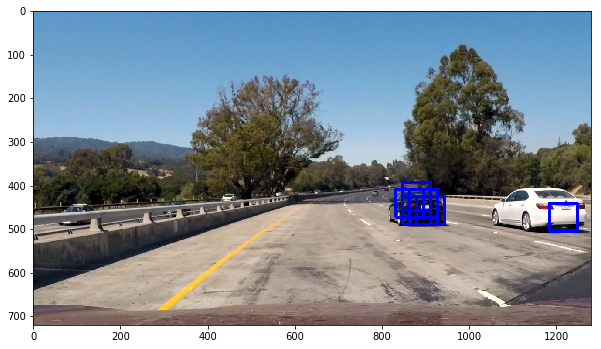

In [10]:
#For Testing purposes

image = mpimg.imread('test_images/test1.jpg')

ystart = round(image.shape[0]/2)
ystop = round(image.shape[0] - 20)
scale = 1.0

print (ystart, ystop)

draw_image = np.copy(image)
'''
cropped_image_to_search = image[ystart:ystop,:,:]
print(image.shape)
print(cropped_image_to_search.shape)

draw_image = np.copy(cropped_image_to_search)

ystart = 0
ystop = cropped_image_to_search.shape[0]
print(ystart, ystop)
'''

rect_windows = find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print(len(rect_windows), 'rect windows found in image')
print(rect_windows)
# Draw detected vehicles on image
detected_vehicles = draw_boxes(draw_image, rect_windows, color=(0,0,255), thickness=6)
plt.figure(figsize=(10,10))
plt.imshow(detected_vehicles)
plt.show() 

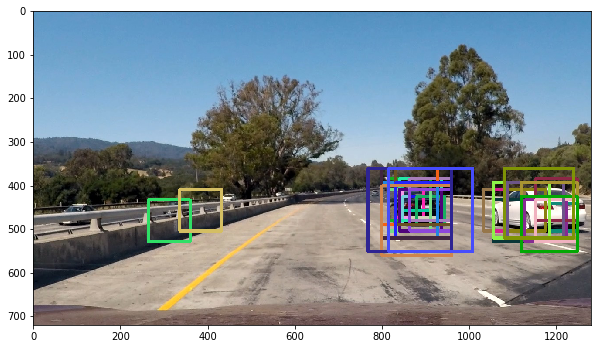

Number of bounding boxes:  36


In [11]:
rect_windows = []

image = mpimg.imread('test_images/test1.jpg')

ystart = round(image.shape[0]/2)
ystop = round(image.shape[0] - 20)
cropped_image_to_search = image[ystart:ystop,:,:]
#draw_image = np.copy(cropped_image_to_search)
draw_image = np.copy(image)

#ystart = 0
#ystop = cropped_image_to_search.shape[0]

scale = 1.0
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')

scale = 1.5
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')

scale = 2.0
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')

scale = 2.5
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')

scale = 3.0
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')
'''
scale = 3.5
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')

scale = 4.0
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')

scale = 4.5
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')

ystart = 400
ystop = 680
scale = 1.0#, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0
rect_windows.append(find_vehicles(draw_image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#print(len(rect_windows), 'rect windows found in image')
'''
bounding_box_list = [item for sublist in rect_windows for item in sublist] 
possible_vehicles = draw_boxes(draw_image, bounding_box_list, color='random', thickness=6)
plt.figure(figsize=(10,10))
plt.imshow(possible_vehicles)
plt.show()
print('Number of bounding boxes: ', len(bounding_box_list))

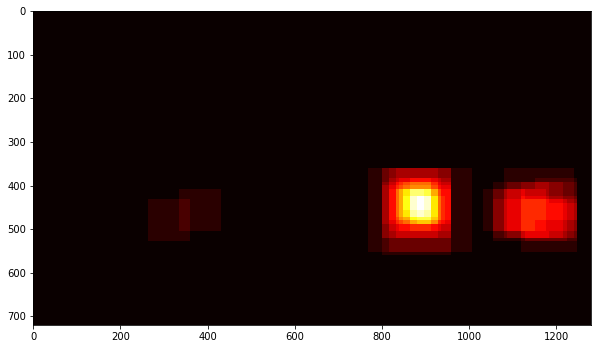

In [12]:
# If the classifier is working well, then the "hot" parts of the map 
# are where the vehicle are. add_heat to determine vehicle locations
heatmap_img = np.zeros_like(draw_image[:,:,0]).astype(np.float)
heatmap_img = add_heat(heatmap_img, bounding_box_list)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

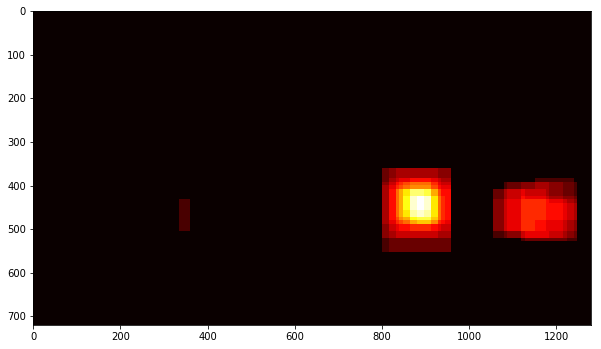

In [13]:
# By applying a threshold limit, you can reject areas 
# affected by false positives and remove areas detected as 
# vehicle locations incorrectly
threshold_limit = 1 #1,2 or 3
heatmap_img = reject_false_positives(heatmap_img, threshold_limit)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

3 Vehicles found


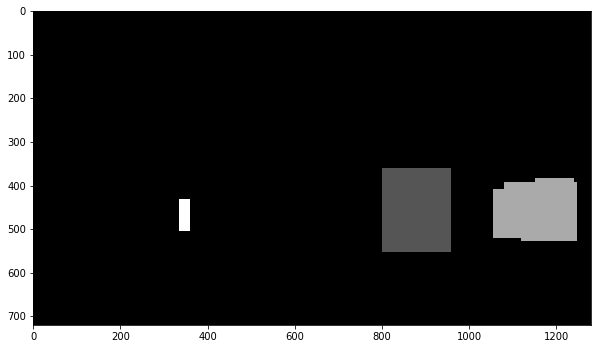

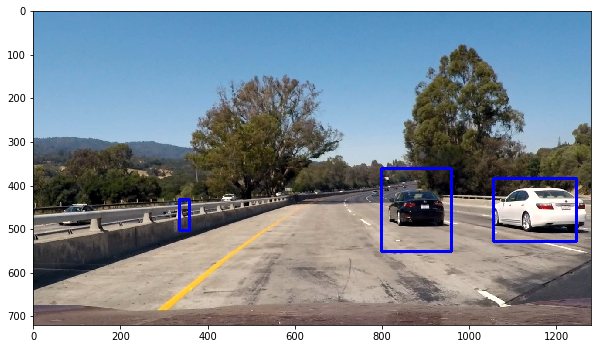

In [14]:
# Once you have a thresholded heat-map, there are many ways you could go 
# about trying to figure out how many cars you have in each frame and 
# which pixels belong to which cars, but one of the most straightforward 
# solutions is to use the label() function from scipy.ndimage.measurements.
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'Vehicles found')

# Draw bounding boxes on a copy of the image
detected_vehicles = draw_labeled_bboxes(np.copy(draw_image), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(detected_vehicles)
plt.show()

In [15]:
# Function to detect vehicles in any image
# Returns bounding bounds list of detected vehicles in an image
def detect_vehicle(image):
    rect_windows = []
    
    ystart = round(image.shape[0]/2)
    ystop = round(image.shape[0] - 20)
    '''
    cropped_image_to_search = image[ystart:ystop,:,:]
    draw_image = np.copy(cropped_image_to_search)
    
    ystart = 0
    ystop = image.shape[0]
    '''
    
    scale = 1.0
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')

    scale = 1.5
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')

    scale = 2.0
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')

    scale = 2.5
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')

    scale = 3.0
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')
    
    scale = 3.5
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')

    scale = 4.0
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')

    scale = 4.5
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')
    '''
    ystart = 400
    ystop = 680
    scale = 1.0#, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0
    rect_windows.append(find_vehicles(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    #print(len(rect_windows), 'rect windows found in image')
    '''
    bounding_box_list = [item for sublist in rect_windows for item in sublist] 
    
    return bounding_box_list

In [16]:
# This is the function that will be called for 
# each frame from a video 
def process_frame(image, threshold_limit=4):
    #cropped_image = crop_image(image)
    #windows = detect_vehicle(cropped_image)
    windows = detect_vehicle(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)
    heat = reject_false_positives(heat, threshold_limit)   
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    # Uncomment the plt lines to test while rendering
    #plt.imshow(draw_img)
    #plt.show()
    return draw_img

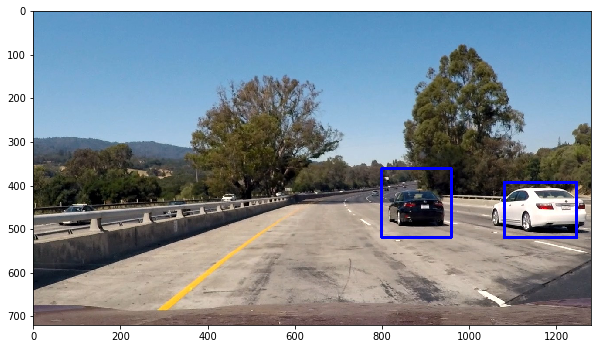

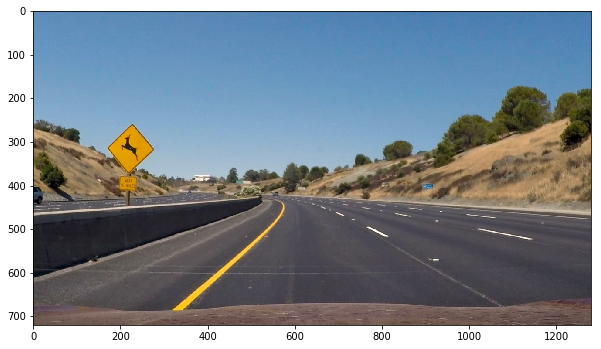

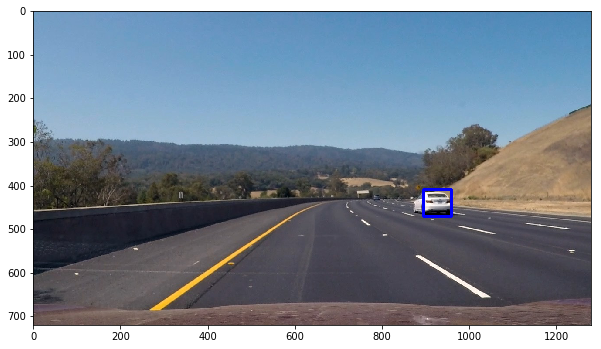

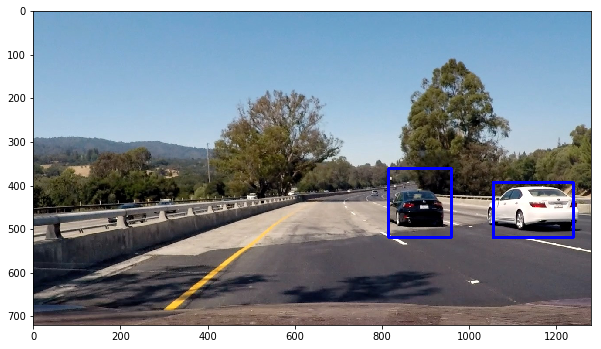

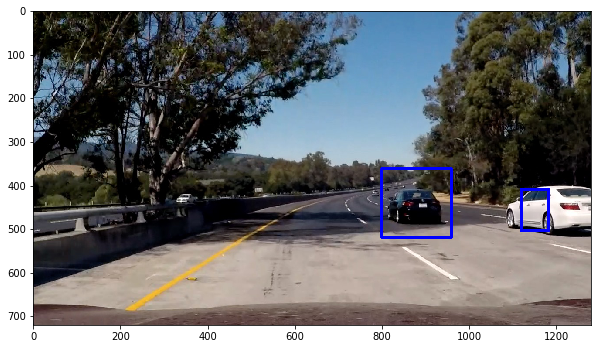

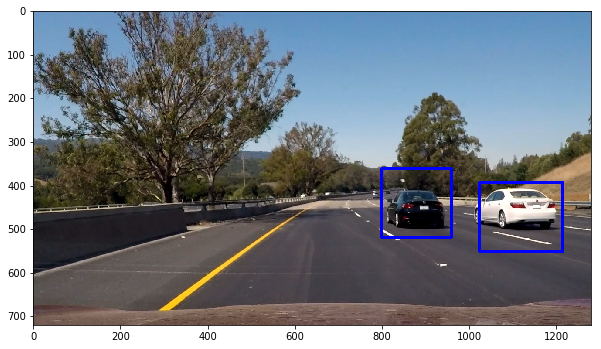

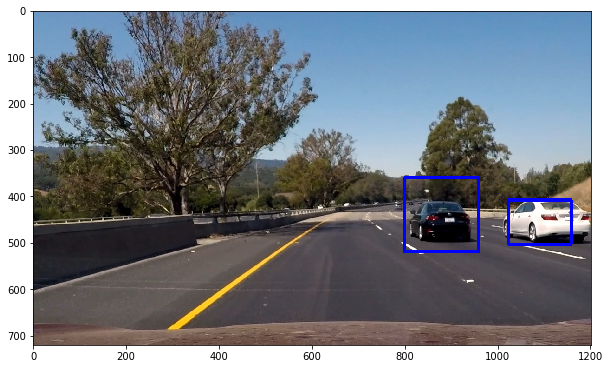

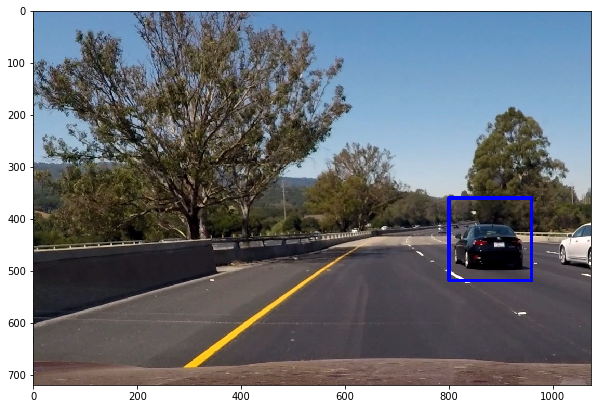

In [17]:
# For testing purposes 
test_images = glob.glob('test_images/*.jpg')
for image_name in test_images:
    image = mpimg.imread(image_name)
    draw_img = process_frame(image, 4)
    
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img)
    plt.show()

In [18]:
from moviepy.editor import VideoFileClip
'''
vehicle_images = glob.glob('datasets/classifying_images/vehicles/*/*.png')
non_vehicle_images =  glob.glob('datasets/classifying_images/non_vehicles/*/*.png')
svc, X_scaler = train_classifier(vehicle_images, non_vehicle_images)
'''
video_output = 'detect_vehicles_&_track.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video detect_vehicles_&_track.mp4
[MoviePy] Writing video detect_vehicles_&_track.mp4


100%|█████████▉| 1260/1261 [31:17<00:01,  1.57s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: detect_vehicles_&_track.mp4 

